# 1. Prepare inputs

## 1. Annotate ±2 kb Promoter Windows with “Open/Closed” Flag

We begin with two BED files (dataset1 and dataset2), each listing 15 promoter windows around TSS:
- Columns: chromosome, start, end, id_base, expr_value, expr_rank, overlaps
- Our goal is to add an `open_flag` (1 or 0) indicating whether that 2 kb window overlaps any skeletal‐muscle ATAC‐seq peak (ENCFF150TGS.bed).
- This tissue‐specific accessibility flag will let us down‐weight or filter variants in closed promoters.

ATAC-seq measures genome-wide chromatin accessibility, and peaks are areas where the chromatin is accessible

In [17]:
import os
import pandas as pd
from pybedtools import BedTool
import numpy as np
from pyfaidx import Fasta
import csv
import pysam

In [2]:
BED1 = "../data/intermediate/dataset1/chr20_test15_tss±2kb.bed"
BED2 = "../data/intermediate/dataset2/chr20_test15_tss±2kb.bed"

# skeletal-muscle ATAC‐seq peaks BED
ATAC_BED = "../data/initial/ENCFF150TGS.bed"

# Output paths (append "_with_open.bed")
OUT1 = BED1.replace(".bed", "_with_open.bed")
OUT2 = BED2.replace(".bed", "_with_open.bed")

In [6]:
def load_promoter_bed(path):
    """
    - `start`/`end` → `int`
    - `expr_value`/`expr_rank` → `float`
    - `id_base`, `chromosome`, `overlaps` → `str`
    """
    cols = ["chromosome","start","end","id_base","expr_value","expr_rank","overlaps"]

    df = pd.read_csv(
        path,
        sep="\t",
        names=cols,
        skiprows=1,
        dtype={
            "chromosome": str,
            "id_base":    str,
            "overlaps":   str
        },
        engine="python"
    )

    df["start"]      = df["start"].astype(int)
    df["end"]        = df["end"].astype(int)
    df["expr_value"] = df["expr_value"].astype(float)
    df["expr_rank"]  = df["expr_rank"].astype(float)

    return df

#df1 = load_promoter_bed(BED1)
#print("Dataset1 promoter windows (first 5 rows):")
#print(df1.head())

## 2. Annotate “open” promoters via intersection

In [7]:
def annotate_open(promoter_df, atac_bed_obj):
    """
    Given a promoter DataFrame (with columns chromosome,start,end,id_base, …),
    create a BedTool from its first four columns, intersect with ATAC peaks,
    then build an 'open_flag' column = 1 if that promoter overlaps any peak, else 0.
    """
    # creating a bedtool from just the first four columns: (chrom, start, end, id_base)
    bed_in = promoter_df[["chromosome","start","end","id_base"]]
    promoter_bed = BedTool.from_dataframe(bed_in)

    # Intersect with ATAC_BED; -u ensures we get each promoter only once if it overlaps
    promoter_open = promoter_bed.intersect(atac_bed_obj, u=True)

    # Build a set of id_base for promoters that overlapped at least one ATAC peak
    open_ids = {f.fields[3] for f in promoter_open}

    # Assign open_flag = 1 if id_base in open_ids, else 0
    promoter_df["open_flag"] = promoter_df["id_base"].apply(lambda g: 1 if g in open_ids else 0)
    return promoter_df

In [8]:
def main():
    atac = BedTool(ATAC_BED)

    print("Annotating dataset1 …")
    df1 = load_promoter_bed(BED1)
    df1_annot = annotate_open(df1, atac)
    # Write out eight columns: (chrom, start, end, id_base, expr_val, expr_rank, overlaps, open_flag)
    df1_annot.to_csv(
        OUT1,
        sep="\t",
        index=False,
        header=False,
        columns=[
            "chromosome","start","end","id_base",
            "expr_value","expr_rank","overlaps","open_flag"
        ]
    )
    print("Wrote:", OUT1)

    print("Annotating dataset2 …")
    df2 = load_promoter_bed(BED2)
    df2_annot = annotate_open(df2, atac)
    df2_annot.to_csv(
        OUT2,
        sep="\t",
        index=False,
        header=False,
        columns=[
            "chromosome","start","end","id_base",
            "expr_value","expr_rank","overlaps","open_flag"
        ]
    )
    print("Wrote:", OUT2)


if __name__ == "__main__":
    main()

Annotating dataset1 …
Wrote: ../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open.bed
Annotating dataset2 …
Wrote: ../data/intermediate/dataset2/chr20_test15_tss±2kb_with_open.bed


## 2. Grow ±2 kb Promoters to 524 kb & One‐Hot Encode

Now that we have our `_with_open.bed` files (with `open_flag`), we next:

1. Read each 2 kb window.
2. Compute its true TSS = `start + 2000`.
3. Expand to ±262 144 bp (total 524 288 bp).
4. Fetch that sequence from hg38 FASTA, padding with “N” if we hit chr ends.
5. One‐hot encode A/C/G/T → 4 × 524 288 float32 array.
6. Save each array as `GENE.npy`, and collect its metadata (path, expr_value, expr_rank, overlaps, open_flag).
7. Dump a `flashzoi_meta.tsv` for each dataset to drive downstream predictions.

In [12]:
IN_BED1 = "../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open.bed"
IN_BED2 = "../data/intermediate/dataset2/chr20_test15_tss±2kb_with_open.bed"

OUT1_BED = "../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open.bed"
OUT2_BED = "../data/intermediate/dataset2/chr20_test15_tss±2kb_with_open.bed"
REF_FASTA = "../data/initial/GRCh38.primary_assembly.genome.fa"

In [13]:
# Flashzoi and Borzoi wants 524 kb windows. That is ±262 kb around the TSS.
FULL_WINDOW = 524_288  # exactly 2^19 = 524,288 bp
HALF_WIN    = FULL_WINDOW // 2  # 262,144

def one_hot_encode(seq):
    """
    Turn an uppercase DNA string into a (4, L) float32 array:
      A → [1,0,0,0]
      C → [0,1,0,0]
      G → [0,0,1,0]
      T → [0,0,0,1]
      anything else (N) → [0,0,0,0]
    """
    # create an array shape (4, len(seq))
    L = len(seq)
    arr = np.zeros((4, L), dtype=np.float32)
    mapping = {'A':0, 'C':1, 'G':2, 'T':3}     # mapping bases to row indices
    for i, base in enumerate(seq):
        if base in mapping:
            arr[mapping[base], i] = 1.0
    return arr

In [14]:
def extract_524kb_onehot(chrom, tss, fasta_obj):
    """
    given chr 20 and TSS coordinate,
    return a (4, 524288) numpy one-hot array.
    If we run off the chromosome edge, we pad with zeros at that side. # TODO: is that okay now
    """
    # coordinates in pyfaidx are 1-based inclusive, so we convert.
    # pyfaidx.Fasta[...] expects something like fasta["chr20"][start-1:end].
    tss0 = tss - 1  # convert to python 0-based, because our TSS is 1-based

    left  = tss0 - HALF_WIN
    right = tss0 + HALF_WIN - 1  # inclusive index so that total length = 524,288

    # If left < 0 or right ≥ chrom length, we’ll pad.
    seq_chars = []
    # part from left..right
    if left < 0:
        # pad on left with Ns
        seq_chars.append("N" * (-left))
        left = 0
    # now retrieve from FASTA
    chrom_seq = fasta_obj[chrom]  # FASTA record object
    chrom_len = len(chrom_seq)
    if right >= chrom_len:
        # fetch from left..end, then pad on right
        seq_chars.append(str(chrom_seq[left:]))  # pyfaidx returns Seq object, cast to str
        pad_len = right - (chrom_len - 1)
        seq_chars.append("N" * pad_len)
    else:
        # normal case: just slice left..right
        seq_chars.append(str(chrom_seq[left : right + 1]))

    final_seq = "".join(seq_chars).upper()
    if len(final_seq) != FULL_WINDOW:
        raise ValueError(
            f"One-hot sequence length mismatch: got {len(final_seq)}, expected {FULL_WINDOW}"
        )

    return one_hot_encode(final_seq)

In [16]:
def prepare_for_flashzoi(in_bed, out_dir_prefix):
    """
    1) Read your 2 kb BED (with expr_value and expr_rank in columns 5/6).
    2) For each line, expand to 524 kb, fetch one-hot, save as .npy,
       and write a small JSON or TSV record of metadata (ID + expr stats).
    """
    # Load the BED with headers (7 columns):
    #  chrom   start   end   id_base  expr_value  expr_rank  overlaps
    cols = ["chromosome","start","end","id_base","expr_value","expr_rank","overlaps","open_flag"]
    df2kb = pd.read_csv(in_bed, sep="\t", comment="#", names=cols)

    fasta = Fasta(REF_FASTA)

    # lets also build a small TSV that maps each sample → expression/value metadata
    meta = []
    for idx, r in df2kb.iterrows():
        gene = r.id_base
        chrom = r.chromosome
        # r.start/r.end = ±2 kb window;
        # but the TSS is actually at (start + 2000) #TODO: ask Philipp this
        tss = r.start + 2000

        # Fetch one-hot  (4 × 524,288)
        onehot = extract_524kb_onehot(chrom, tss, fasta)

        # Save one-hot to .npy
        out_npy = os.path.join(out_dir_prefix, f"{gene}.npy")
        np.save(out_npy, onehot)

        # Record metadata for downstream:
        #   gene, TPM, expr_rank, any overlaps (2 kb overlap list), and path to .npy
        meta.append({
            "gene":        gene,
            "onehot_path": out_npy,
            "expr_value":  float(r.expr_value),
            "expr_rank":   float(r.expr_rank),
            "overlaps2kb": r.overlaps
        })

        print(f"[{idx+1}/{len(df2kb)}] Saved {gene}.npy")

    # Dump metadata TSV so we can join predictions back to expr later
    meta_df = pd.DataFrame(meta)
    meta_df.to_csv(os.path.join(out_dir_prefix, "flashzoi_meta.tsv"),
                   sep="\t", index=False)

    print("Done prepping")


if __name__=="__main__":
    # creating now one folder per dataset to hold .npy + meta.tsv
    ds1_dir = os.path.join(OUT1_BED.replace(".bed",""), "flashzoi_inputs")
    ds2_dir = os.path.join(OUT2_BED.replace(".bed",""), "flashzoi_inputs")
    os.makedirs(ds1_dir, exist_ok=True)
    os.makedirs(ds2_dir, exist_ok=True)

    print("Preparing dataset1...")
    prepare_for_flashzoi(IN_BED1, ds1_dir)

    print("Preparing dataset2...")
    prepare_for_flashzoi(IN_BED2, ds2_dir)

    print("Saved 524 kb one-hot inputs + a meta.tsv for each dataset")

Preparing dataset1...
[1/15] Saved ENSG00000077984.npy
[2/15] Saved ENSG00000197122.npy
[3/15] Saved ENSG00000101333.npy
[4/15] Saved ENSG00000020256.npy
[5/15] Saved ENSG00000170191.npy
[6/15] Saved ENSG00000149639.npy
[7/15] Saved ENSG00000088827.npy
[8/15] Saved ENSG00000124217.npy
[9/15] Saved ENSG00000089123.npy
[10/15] Saved ENSG00000171940.npy
[11/15] Saved ENSG00000089057.npy
[12/15] Saved ENSG00000101052.npy
[13/15] Saved ENSG00000131061.npy
[14/15] Saved ENSG00000158445.npy
[15/15] Saved ENSG00000196839.npy
Done prepping
Preparing dataset2...
[1/15] Saved ENSG00000171984.npy
[2/15] Saved ENSG00000101000.npy
[3/15] Saved ENSG00000078699.npy
[4/15] Saved ENSG00000125821.npy
[5/15] Saved ENSG00000130699.npy
[6/15] Saved ENSG00000080189.npy
[7/15] Saved ENSG00000126005.npy
[8/15] Saved ENSG00000130703.npy
[9/15] Saved ENSG00000243509.npy
[10/15] Saved ENSG00000088298.npy
[11/15] Saved ENSG00000042062.npy
[12/15] Saved ENSG00000125971.npy
[13/15] Saved ENSG00000101216.npy
[14/15] 

## 3. Annotate variants

In [27]:
META_TSV      = "../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open/flashzoi_inputs/flashzoi_meta.tsv"
MANE_SUMMARY  = "../data/initial/MANE.GRCh38.v1.4.summary.txt"
GNOMAD_VCF    = "../data/initial/gnomad.genomes.v4.1.sites.chr20.vcf.bgz"
OUT_BASE      = "../data/intermediate/dataset1/flashzoi_inputs/variants"
# Fixed half‐window for a 524 kb total (262 144 = 524 288/2)
HALF_WIN = 262_144
CHROM    = "chr20"
EDGE_BUFFER   = 100_000    # skip genes whose TSS is within 100 kb of a chromosome end
MIN_AF        = 0.001      # drop variants with AF < 0.001


- META_TSV: this is the per-gene meta file generated when we one-hot-encoded ±2 kb windows (contains gene, onehot_path, expr_value, expr_rank, overlaps2kb, and open_flag column).
- MANE_SUMMARY: to re-derive each gene’s canonical TSS (for computing ±262 kb genomic window)
- GNOMAD_VCF: bgzipped, indexed VCF of chr20 population variants, to get allele frequencies
- OUT_BASE: we’ll drop one subdirectory per gene here, each containing its ENSG…_variants.tsv.


## 1. build a map gene_id → TSS for cr20 only

In [28]:
def load_mane_tss(mane_path):
    """
    Reads the MANE summary file, drops duplicate Ensembl_Gene entries,
    strips off ".N" from Ensembl IDs, normalizes NC_000020.## → chr20,
    and returns a dict { gene_base → TSS } for only chr20.
    """
    df = pd.read_csv(mane_path, sep="\t", dtype=str).drop_duplicates(subset="Ensembl_Gene")
    # Strip off version suffix
    df["gene_base"] = df["Ensembl_Gene"].str.replace(r"\.\d+$", "", regex=True)

    # Convert "NC_000020.11" → "chr20"
    df["chromosome"] = df["GRCh38_chr"].str.replace(
        r"^NC_0+(\d+)\.\d+$", r"chr\1", regex=True
    )

    # Compute TSS: if '+' strand → chr_start, else ( '-' strand ) → chr_end
    def get_tss(row):
        return int(row["chr_start"]) if row["chr_strand"] == "+" else int(row["chr_end"])

    df["TSS"] = df.apply(get_tss, axis=1)

    # keeping only chr20
    df20 = df[df["chromosome"] == CHROM].copy()
    return dict(zip(df20["gene_base"], df20["TSS"]))

## 2. Write the header of a per‐gene variants TSV

In [29]:
def write_variants_header(outfile):
    """
    Creates a TSV with columns:
       CHROM, POS, POS0, REF, ALT, AF
    """
    with open(outfile, "w", newline="") as fo:
        writer = csv.writer(fo, delimiter="\t")
        writer.writerow([
            "CHROM", "POS", "POS0", "REF", "ALT", "AF"
        ])

## 3. Annotate each gene’s ±262 kb window

In [30]:
def annotate_variants(meta_tsv, mane_summary, vcf_path, out_base):
    # 1) loading flashzoi_meta.tsv (must have a column "gene" = Ensembl ID without version)
    meta_df = pd.read_csv(meta_tsv, sep="\t")
    print(f"Loaded metadata for {len(meta_df)} genes.")

    # 2) Build the gene→TSS map for chr20
    tss_dict = load_mane_tss(mane_summary)
    print(f"Found {len(tss_dict)} chr20 entries in MANE summary.")

    # 3) opening the gnomAD VCF
    vcf = pysam.VariantFile(vcf_path)
    print("Opened gnomAD VCF:", vcf_path)

    #fetch chr length for edge filtering
    fasta = Fasta(REF_FASTA)
    chr_len = len(fasta[CHROM])


    # 4) over each gene in meta_df
    for idx, row in meta_df.iterrows():
        gene = row["gene"]
        if gene not in tss_dict:
            print(f"[{idx+1}/{len(meta_df)}] SKIP {gene} (no chr20 TSS).")
            continue

        # Compute that gene’s ±262 144 window (with 1-based coordinates)
        tss  = tss_dict[gene]
        # skipping genes too close to telomeres
        if tss < EDGE_BUFFER or (chr_len - tss) < EDGE_BUFFER:
            print(f"[{idx+1}/{len(meta_df)}] SKIP {gene}: TSS at {tss:,} within {EDGE_BUFFER} bp of chr end")
            continue

        left = max(1, tss - HALF_WIN)
        right= tss + HALF_WIN - 1
        print(f"[{idx+1}/{len(meta_df)}] {gene}: window = {left}-{right}")

        gene_dir = os.path.join(out_base, gene)
        os.makedirs(gene_dir, exist_ok=True)

        var_tsv = os.path.join(gene_dir, f"{gene}_variants.tsv")
        write_variants_header(var_tsv)

        # 5) Fetch variants from chr20 between (left - 1, right) in pysam (0-based half-open)
        # 5) Fetch & filter variants
        for rec in vcf.fetch(CHROM, left - 1, right):
            chrom = rec.chrom
            pos   = rec.pos
            pos0  = pos - left
            ref   = rec.ref

            # Pull AF and apply threshold
            af_val = "NA"
            if "AF" in rec.info and rec.info["AF"] is not None:
                entry = rec.info["AF"]
                af_val = entry[0] if isinstance(entry, (tuple,list)) else entry
                if af_val < MIN_AF:
                    continue

            for alt in rec.alts:
                with open(var_tsv, "a", newline="") as fo:
                    writer = csv.writer(fo, delimiter="\t")
                    writer.writerow([
                        chrom, pos, pos0,
                        ref, alt,
                        f"{af_val:.6f}" if af_val!="NA" else af_val
                    ])

        print(f"Wrote variants to {var_tsv}")

    vcf.close()
    print("Done annotating variants for all genes.")


if __name__ == "__main__":
    os.makedirs(OUT_BASE, exist_ok=True)

    print("Annotating 524 kb windows with gnomAD chr20 variants…")
    annotate_variants(META_TSV, MANE_SUMMARY, GNOMAD_VCF, OUT_BASE)
    print("All variant‐lists are under:", OUT_BASE)

Annotating 524 kb windows with gnomAD chr20 variants…
Loaded metadata for 15 genes.
Found 524 chr20 entries in MANE summary.
Opened gnomAD VCF: ../data/initial/gnomad.genomes.v4.1.sites.chr20.vcf.bgz
[1/15] ENSG00000077984: window = 24687125-25211412
Wrote variants to ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000077984/ENSG00000077984_variants.tsv
[2/15] ENSG00000197122: window = 37083996-37608283
Wrote variants to ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000197122/ENSG00000197122_variants.tsv
[3/15] ENSG00000101333: window = 8806943-9331230
Wrote variants to ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000101333/ENSG00000101333_variants.tsv
[4/15] ENSG00000020256: window = 51929635-52453922
Wrote variants to ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000020256/ENSG00000020256_variants.tsv
[5/15] ENSG00000170191: window = 25361870-25886157
Wrote variants to ../data/intermediate/dataset1/flashzoi_inputs/variants/EN

## 4. Checking final data

In [41]:
import glob, pandas as pd
counts = {}
for tsv in glob.glob("../data/intermediate/dataset1/flashzoi_inputs/variants/*/*.tsv"):
    gene = tsv.split("/")[-2]
    df   = pd.read_csv(tsv, sep="\t")
    counts[gene] = len(df)
print(pd.Series(counts).describe())
# TODO: should we cap the max number variants per gene? or moving the AF filter higher? avg is 18k variants per gene, but one has 150k?

count        17.000000
mean      18341.882353
std       35480.147880
min        6074.000000
25%        7095.000000
50%        7534.000000
75%        7717.000000
max      149267.000000
dtype: float64


### 2. Allele freq distribution

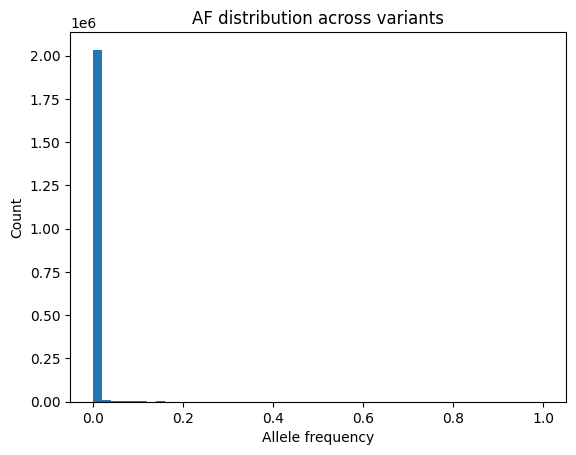

In [44]:
import glob, pandas as pd
import matplotlib.pyplot as plt

paths = glob.glob("../data/output/dataset1/flashzoi_inputs/variants/*/*.tsv")

#print(f"Found {len(paths)} per-gene variant files; e.g. {paths[:3]}")

# build the AF histogram
all_af = pd.concat([
    pd.read_csv(tsv, sep="\t")["AF"]
        .astype(float)
        .dropna()
    for tsv in paths
], ignore_index=True)

plt.hist(all_af, bins=50)
plt.xlabel("Allele frequency")
plt.ylabel("Count")
plt.title("AF distribution across variants")
plt.show()

In [46]:
VAR_DIR   = "../data/intermediate/dataset1/flashzoi_inputs/variants"
example = glob.glob(os.path.join(VAR_DIR, "*", "*_variants.tsv"))[0]
print("Example file:", example)
pd.read_csv(example, sep="\t").head()

Example file: ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000131061/ENSG00000131061_variants.tsv


,CHROM,POS,POS0,REF,ALT,AF
0,chr20,33471042,1190,A,G,0.001021
1,chr20,33471186,1334,T,C,0.001342
2,chr20,33471221,1369,C,A,0.010552
3,chr20,33471221,1369,C,CA,0.015539
4,chr20,33471221,1369,CA,C,0.003863
